# Content
* Libraries
* Introduction to Problem
    * Loading Dataset
    * Visualizing Raw Dataset
    * Preprocessing
    * Visualizing Proprocessed Dataset
* Logistic Regression with numpy
    * Forward Propagation
    * Backward Propagation
    * Complete Propagation
    * Combining All Together
    * Training
    * Prediction
    * Evaluation
* Logistic Regression with tensorflow
    * Just Forward Propagation
    * Training and Evaluation
* Logistic Regression with keras
    * Just Layer Description
    * Training
    * Evaluation

# Libraries

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from utils import plot_prediction

# Introduction to Problem
Given a set of inputs X as features of flowers, we want to assign them to one of two possible categories 0 or 1 that means what type of flower they are.
For solving this problem we use logistic regression because it models the probability that each input belongs to a particular category.

## Loading Dataset

How many features this dataset have? <br>
What is the label for this problem?

In [170]:
iris = pd.read_csv('./data/Iris.csv')
iris.sample(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
122,123,7.7,2.8,6.7,2.0,Iris-virginica
23,24,5.1,3.3,1.7,0.5,Iris-setosa
77,78,6.7,3.0,5.0,1.7,Iris-versicolor
31,32,5.4,3.4,1.5,0.4,Iris-setosa
89,90,5.5,2.5,4.0,1.3,Iris-versicolor


In [168]:
print("Number of Flowers: {}".format(iris.shape[0]))

Number of Flowers: 150


## Visualizing Dataset

C:\Users\Erfan\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


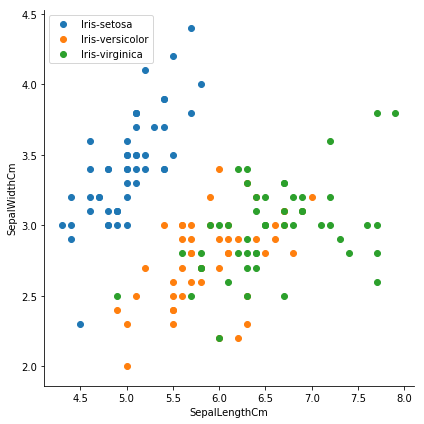

In [3]:
sepalPlt = sb.FacetGrid(iris, hue="Species", size=6).map(plt.scatter, "SepalLengthCm", "SepalWidthCm")
plt.legend(loc='upper left')

## Preprocessing

In this step we will simplify the problem into a binary classification problem with just 2 features.

In [4]:
X = iris.iloc[:, 1:3]
Y = (iris['Species'] != 'Iris-setosa') * 1

We devide data to train and test sets:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

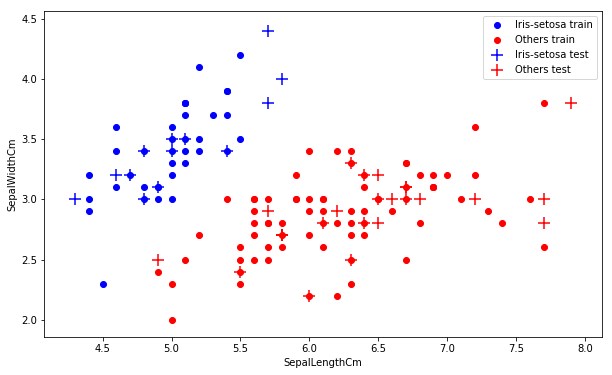

In [177]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], color='b', label='Iris-setosa train')
plt.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], color='r', label='Others train')
plt.scatter(X_test[y_test == 0].iloc[:, 0], X_test[y_test == 0].iloc[:, 1], color='b', label='Iris-setosa test', marker='+', s=150)
plt.scatter(X_test[y_test == 1].iloc[:, 0], X_test[y_test == 1].iloc[:, 1], color='r', label='Others test', marker='+', s=150)
plt.xlabel('SepalLengthCm')
plt.ylabel('SepalWidthCm')
plt.legend()

<h1 style="text-align:center">Questions</h1>

## Logistic Regression
  <a href="https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8">Logistic Regression</a> is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.
![logistic_regression](figs/logistic_regression.png)

\begin{align}
Z = w_1x_1+w_2x_2+\dots+w_nx_n + b
\end{align}

## Forward Propagation

First we will implement linear multiplication:

$$W=\begin{bmatrix}w_1, & w_2, & \dots & w_n \end{bmatrix}$$
$$X=\begin{bmatrix}x_1, & x_2, & \dots & x_n \end{bmatrix}$$

\begin{align}
Z = W^TX + b
\end{align}

In [7]:
def linear_mult(X, w, b):
    return np.dot(w.T, X) + b

Now we implement a function could generate W and b for us:

In [8]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

Next we will implement sigmoid function to map calculated value to a probablity:

![sigmoid_function](figs/sigmoid.png)

\begin{align}
A = \sigma(Z) = \frac{1}{1 + e^{-Z}}
\end{align}

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Now we implement the cost function, cost function represent the difference between our predictions and actual labels(y is the actual label and a is our predicted label):

\begin{align}
J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(A^{(i)})+(1-y^{(i)})\log(1-A^{(i)})
\end{align}

In [10]:
def cost_function(y, a):
    return -np.mean(y*np.log(a) + (1-y)*np.log(1-a))

Now we implement the whole forward propagation which will calculate cost and the predicted value for the each data point:

In [11]:
def forward_propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    Z = linear_mult(X, w, b)
    A = sigmoid(Z)                                 
    cost = cost_function(Y, A)  
    cost = np.squeeze(cost)

    assert(cost.shape == ())
    
    back_require = {
        'A': A
    }
    
    return back_require, cost

## Backward Propagation

Now we calculate W and b derivative as follow:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [12]:
def backward_propagate(w, b, X, Y, back_require):
    
    m = X.shape[1]
    
    A = back_require['A']
    
    dw = (1/m) * np.dot(X,(A-Y).T)
    db = (1/m) * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads

# Complete Propagation

In [13]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    # FORWARD PROPAGATION
    back_require, cost = forward_propagate(w, b, X, Y)
    
    # BACKWARD PROPAGATION
    grads = backward_propagate(w, b, X, Y, back_require)

    
    return grads, cost

# Combining All Together

Now we combine all our implemented functions together to create an optimizer which can find a linear function to devide the zero labeled data from one labeled data points by optimizng W and b as follow:
$$W=W−\alpha{dw}$$
$$b=b−\alpha{db}$$
$\alpha$ is the learning rate

![sigmoid_function](figs/gradient_w.gif)

![sigmoid_function](figs/8yDt.gif)

In [159]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads["dw"]
        db = grads["db"]
        

        w -= learning_rate*dw
        b -= learning_rate*db
        
        # Record the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## Training

In [160]:
%%time
X_train_t, y_train_t = np.array(X_train.T), np.array(y_train.T)
w, b = initialize_with_zeros(2)
params, grads, costs = optimize(w, b, X_train_t, y_train_t, num_iterations= 800, learning_rate = 0.1, print_cost = False)

Wall time: 50.9 ms


Text(0, 0.5, 'Cost(loss) value')

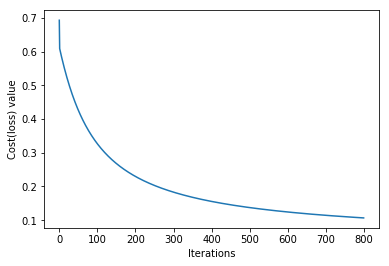

In [161]:
plt.plot(range(len(costs)),costs)
plt.xlabel('Iterations')
plt.ylabel('Cost(loss) value')

# Prediction

In [20]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    
    Z = linear_mult(X, w, b)
    A = sigmoid(Z)
    
    for i in range(m):
        Y_prediction[0][i] = 1 if A[0][i] > .5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

# Evaluation

In [22]:
preds = predict(params['w'], params['b'], X_train_t)
print('Accuracy on training set: %{}'.format((preds[0] == y_train).mean()*100))

Accuracy on training set: %99.10714285714286


In [24]:
preds = predict(params['w'], params['b'], X_train_t)
print('Accuracy on training set: %{}'.format((preds[0] == y_train).mean()*100))
preds = predict(params['w'], params['b'], np.array(X_test.T))
print('Accuracy on test set: %{}'.format((preds[0] == y_test).mean()*100))

Accuracy on training set: %99.10714285714286
Accuracy on test set: %100.0


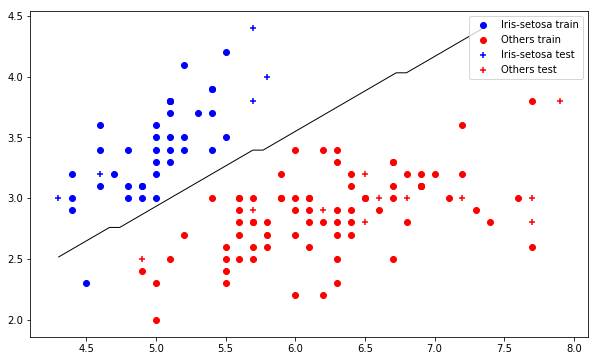

In [154]:
plot_prediction(X_train, y_train, X_test, y_test, predict, params)

# Logistic Regression with tensorflow

## Just Forward Propagation

In [191]:
y_test = np.array(y_test).astype(np.float32).reshape(-1,1)
y_train = np.array(y_train).astype(np.float32).reshape(-1,1)

graph = tf.Graph()
with graph.as_default():
    with tf.device("/cpu:0"):

        # Input data.
        # Load the training, validation and test data into constants that are
        # attached to the graph.
        X_data = tf.placeholder(tf.float32, shape=(None, 2))
        y_data = tf.placeholder(tf.float32 , shape=(None, 1))

        # Variables.
        # These are the parameters that we are going to be training. The weight
        # matrix will be initialized using random values following a (truncated)
        # normal distribution. The biases get initialized to zero.
        weights = tf.Variable(tf.truncated_normal([2, 1]))
        biases = tf.Variable(tf.zeros([1]))

        # Training computation.
        # We multiply the inputs with the weight matrix, and add biases. We compute
        # the softmax and cross-entropy (it's one operation in TensorFlow, because
        # it's very common, and it can be optimized). We take the average of this
        # cross-entropy across all training examples: that's our loss.
        logits = tf.matmul(X_data, weights) + biases
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_data, logits=logits))

        # Optimizer.
        # We are going to find the minimum of this loss using gradient descent.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        # These are not part of training, but merely here so that we can report
        # accuracy figures as we train.
        prediction = tf.nn.sigmoid(logits)

## Training and Evaluation

Initialized
Loss at step 0: 2.653436
Training accuracy: 33.0%
Loss at step 100: 0.112133
Training accuracy: 99.1%
Loss at step 200: 0.086459
Training accuracy: 99.1%
Loss at step 300: 0.074192
Training accuracy: 99.1%
Loss at step 400: 0.066845
Training accuracy: 99.1%
Loss at step 500: 0.061882
Training accuracy: 99.1%
Loss at step 600: 0.058268
Training accuracy: 99.1%
Loss at step 700: 0.055495
Training accuracy: 99.1%
Test accuracy: 100.0%
Wall time: 647 ms


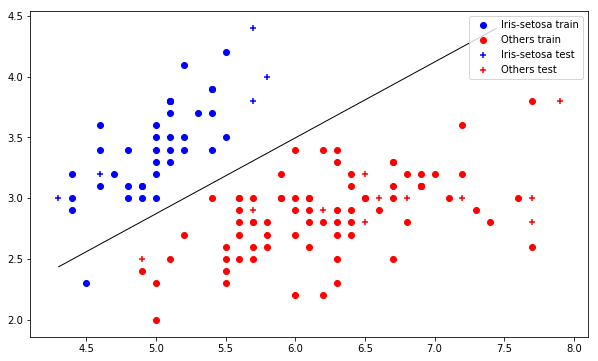

In [194]:
%%time
num_steps = 800

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        d, l, predictions = session.run([optimizer, loss, prediction], 
                                        feed_dict={X_data: X_train.astype(np.float32), y_data: y_train})
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, y_train))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
    print('Test accuracy: %.1f%%' % accuracy(
    prediction.eval(feed_dict={X_data: X_test.astype(np.float32)}), y_test))
    plot_prediction(X_train, y_train, X_test, y_test, prediction, params, fm_type='tensorflow') #TODO

# Keras

## Just Layer Description

In [185]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, input_shape=(2,))
])
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training

In [186]:
%%time
history = model.fit(X_train, y_train, epochs=800, verbose=0)

Wall time: 7.25 s


Text(0, 0.5, 'Accuracy value')

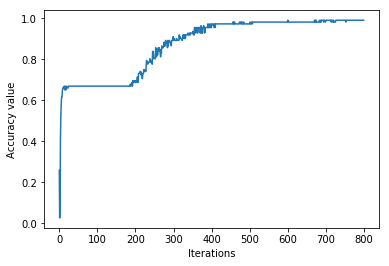

In [187]:
plt.plot(range(len(history.history['acc'])),history.history['acc'])
plt.xlabel('Iterations')
plt.ylabel('Accuracy value')

## Evaluation

In [188]:
print('Test accuracy: %.1f%%' % accuracy(
                            model.predict(X_train.astype(np.float32)), y_train))
print('Test accuracy: %.1f%%' % accuracy(
                            model.predict(X_test.astype(np.float32)), y_test))

Test accuracy: 99.1%
Test accuracy: 100.0%


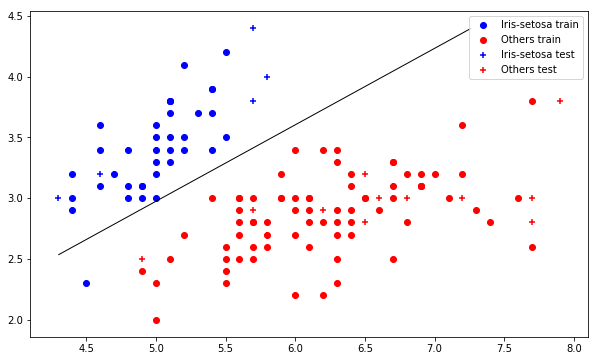

In [189]:
plot_prediction(X_train, y_train, X_test, y_test, model.predict, params, fm_type='keras')

# Further Reading

* Tensorflow Playground: https://playground.tensorflow.org/
* First Week of Neural Networks Course: https://www.coursera.org/learn/neural-networks-deep-learning